In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_matches = pd.read_csv('../data/preprocessed/preprocessed_1.csv')

In [3]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score


def train_and_evaluate(train_df, val_df, test_df):
    X_train = train_df.drop(columns=["result_match", "season", "date", "home_team", "away_team"])
    y_train = train_df["result_match"]

    X_val = val_df.drop(columns=["result_match", "season", "date", "home_team", "away_team"])
    y_val = val_df["result_match"]

    X_tst = test_df.drop(columns=["result_match", "season", "date", "home_team", "away_team"])
    y_tst = test_df["result_match"]

    model = XGBClassifier(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        random_state=42,
        use_label_encoder=False,
        eval_metric="logloss",
    )
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=False)

    y_pred = model.predict(X_tst)

    f1 = f1_score(y_tst, y_pred)
    return f1

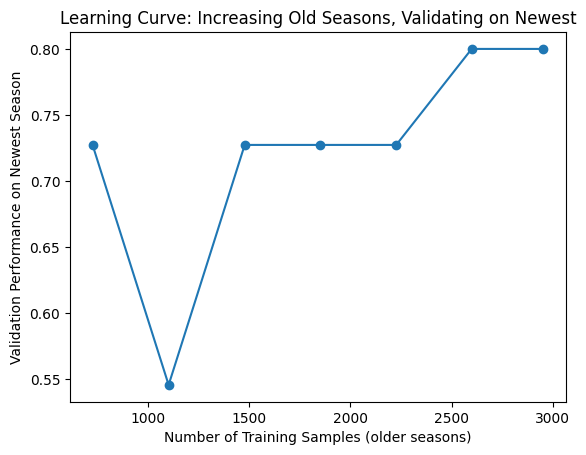

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

sorted_seasons = sorted(df_matches["season"].unique())
newest_season = sorted_seasons[-1]
older_seasons = sorted_seasons[:-1]

max_stage = df_matches.loc[df_matches["season"] == newest_season, "stage"].max()
penultimate_stage = max_stage - 1

train_sizes = []
performances = []

for i in range(1, len(older_seasons) + 1):
    train_seasons = sorted(older_seasons[-i:], reverse=True)

    train_df_older_seasons = df_matches[df_matches["season"].isin(train_seasons)]
    train_df_newest = df_matches[(df_matches["season"] == newest_season) & (df_matches["stage"] < penultimate_stage)]
    train_df = pd.concat([train_df_older_seasons, train_df_newest], ignore_index=True)

    val_df = df_matches[
        (df_matches["season"] == newest_season)
        & (df_matches["stage"] == penultimate_stage)
        ]

    test_df = df_matches[
        (df_matches["season"] == newest_season)
        & (df_matches["stage"] == max_stage)
        ]

    performance_metric = train_and_evaluate(train_df, val_df, test_df)

    train_sizes.append(len(train_df))
    performances.append(performance_metric)

learning_curve_df = pd.DataFrame({
    'train_size': train_sizes,
    'performance': performances
})

plt.plot(learning_curve_df['train_size'], learning_curve_df['performance'], marker='o')
plt.xlabel('Number of Training Samples (older seasons)')
plt.ylabel('Validation Performance on Newest Season')
plt.title('Learning Curve: Increasing Old Seasons, Validating on Newest')
plt.show()

In [10]:
df_matches = df_matches.sort_values(by=["season", "stage", "date"])

train_seasons = sorted(older_seasons[-6:], reverse=True)

X_train_old = df_matches[df_matches["season"].isin(train_seasons)]
X_train_new = df_matches[(df_matches["season"] == newest_season) & (df_matches["stage"] < penultimate_stage)]

df_train = pd.concat([X_train_old, X_train_new], ignore_index=True, )
df_val = df_matches[(df_matches["season"] == newest_season) & (df_matches["stage"] == penultimate_stage)].reset_index(
    drop=True)
df_tst = df_matches[(df_matches["season"] == newest_season) & (df_matches["stage"] == max_stage)].reset_index(drop=True)

X_trn = df_train.drop(columns=["match_api_id", "result_match", "season", "stage", "date", "home_team", "away_team"])
y_trn = df_train["result_match"]

X_val = df_val.drop(columns=["match_api_id", "result_match", "season", "stage", "date", "home_team", "away_team"])
y_val = df_val["result_match"]

X_tst = df_tst.drop(columns=["match_api_id", "result_match", "season", "stage", "date", "home_team", "away_team"])
y_tst = df_tst["result_match"]

In [11]:
X_trn.filter(like="difference")

,strength_difference,aggression_difference,acceleration_difference,points_difference
0,-0.242424,-6.545455,3.363636,0
1,-6.010606,9.006061,0.568182,0
2,14.825758,28.890909,-4.918182,0
3,2.874242,-0.692424,-5.480303,0
4,8.710606,3.340909,-2.340909,0
...,...,...,...,...
2594,2.727273,1.381818,3.409091,-15
2595,2.831169,13.755844,-16.979221,-17
2596,-1.223377,7.057143,-6.945455,-10
2597,0.272727,23.127273,-5.390909,-15


In [12]:
(X_trn
 .assign(result_match=y_trn)
 .corr(method='spearman')
 .style
 .background_gradient(cmap='RdBu', vmax=1, vmin=-1)
 .set_sticky(axis='index')
 )

,points_home,points_away,home_last_team_goal,home_last_team_shoton,home_last_team_possession,away_last_team_goal,away_last_team_shoton,away_last_team_possession,team_strength_home,team_strength_away,strength_difference,team_aggression_home,team_aggression_away,aggression_difference,team_acceleration_home,team_acceleration_away,acceleration_difference,points_difference,rolling_avg_goals_home,rolling_avg_goals_away,goal_conversion_rate_home,goal_conversion_rate_away,result_match
points_home,1.000000,0.784192,0.092188,0.039897,-0.066052,0.026288,0.009274,-0.027296,0.079583,0.027580,0.031624,0.064931,0.020032,0.038566,0.100939,-0.038251,0.096945,0.294892,0.027139,0.012565,0.033531,0.010552,0.141648
points_away,0.784192,1.000000,0.001243,-0.042875,0.006266,0.136718,0.075629,-0.095430,0.040241,0.086086,-0.035279,0.002487,0.089501,-0.060465,-0.051594,0.112327,-0.114034,-0.320157,-0.009306,0.051523,0.026689,0.047212,-0.046727
home_last_team_goal,0.092188,0.001243,1.000000,0.081930,-0.075918,-0.002867,0.015202,-0.025742,-0.023337,0.004099,-0.015839,-0.014740,0.016539,-0.014282,0.121037,0.011940,0.078409,0.128530,0.434311,0.039003,0.668213,-0.018908,0.052083
home_last_team_shoton,0.039897,-0.042875,0.081930,1.000000,-0.236675,-0.009522,0.004026,-0.003647,0.042193,0.012047,0.029411,0.027201,-0.002811,0.021533,0.116307,-0.006507,0.096211,0.129532,0.040582,-0.039521,-0.654887,-0.003896,0.081515
home_last_team_possession,-0.066052,0.006266,-0.075918,-0.236675,1.000000,0.006128,-0.001154,-0.007409,-0.004148,-0.019975,0.007238,-0.024580,-0.029289,0.007438,-0.088572,0.012772,-0.078957,-0.105641,-0.028941,-0.012282,0.112447,0.003797,-0.066661
away_last_team_goal,0.026288,0.136718,-0.002867,-0.009522,0.006128,1.000000,0.086668,-0.073842,0.002109,0.072263,-0.049698,0.008598,0.057341,-0.040061,-0.009424,0.119147,-0.083767,-0.167742,0.045562,0.423559,0.008323,0.678785,-0.073658
away_last_team_shoton,0.009274,0.075629,0.015202,0.004026,-0.001154,0.086668,1.000000,-0.197719,0.007115,0.058008,-0.039862,-0.000219,0.034278,-0.020127,0.016886,0.127267,-0.081229,-0.100190,-0.015478,0.030942,0.014340,-0.640502,-0.079728
away_last_team_possession,-0.027296,-0.095430,-0.025742,-0.003647,-0.007409,-0.073842,-0.197719,1.000000,0.011281,-0.041155,0.035805,0.006543,-0.044641,0.038087,0.019950,-0.075111,0.066061,0.116888,-0.039464,0.013795,-0.027788,0.086414,0.065203
team_strength_home,0.079583,0.040241,-0.023337,0.042193,-0.004148,0.002109,0.007115,0.011281,1.000000,0.019663,0.680292,0.702288,0.060325,0.458855,-0.135139,-0.018371,-0.099909,0.057212,-0.021547,-0.005434,-0.048770,-0.003101,0.041764
team_strength_away,0.027580,0.086086,0.004099,0.012047,-0.019975,0.072263,0.058008,-0.041155,0.019663,1.000000,-0.679436,0.044100,0.708517,-0.488183,-0.063539,-0.133417,0.066913,-0.087892,-0.016684,0.033501,-0.003856,0.015206,-0.043259


In [30]:
X_trn.filter(like='acceleration_difference').describe().round(2)

,acceleration_difference
count,2599.00
mean,0.01
std,7.56
min,-30.68
25%,-4.96
50%,0.15
75%,5.28
max,24.47


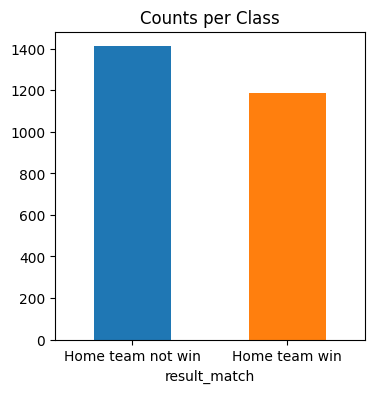

In [17]:
fig, ax = plt.subplots(figsize=(4, 4))
y_trn.value_counts().plot(
    kind='bar',
    ax=ax,
    color=['tab:blue', 'tab:orange']
)
ax.set_title('Counts per Class')
ax.set_xticklabels(['Home team not win', 'Home team win'], rotation=0)
plt.show()

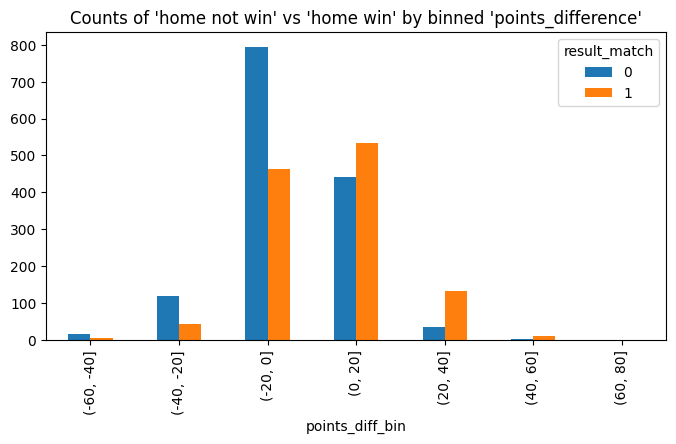

In [21]:
bins = pd.cut(
    X_trn['points_difference'],
    bins=[-60, -40, -20, 0, 20, 40, 60, 80],
)

X_train = X_trn.assign(result_match=y_trn)
X_train['points_diff_bin'] = bins

fig, ax = plt.subplots(figsize=(8, 4))
(
    X_train
    .groupby('points_diff_bin', observed=False)['result_match']
    .value_counts()
    .unstack()
    .plot.bar(ax=ax)
)
ax.set_title("Counts of 'home not win' vs 'home win' by binned 'points_difference'")
plt.show()

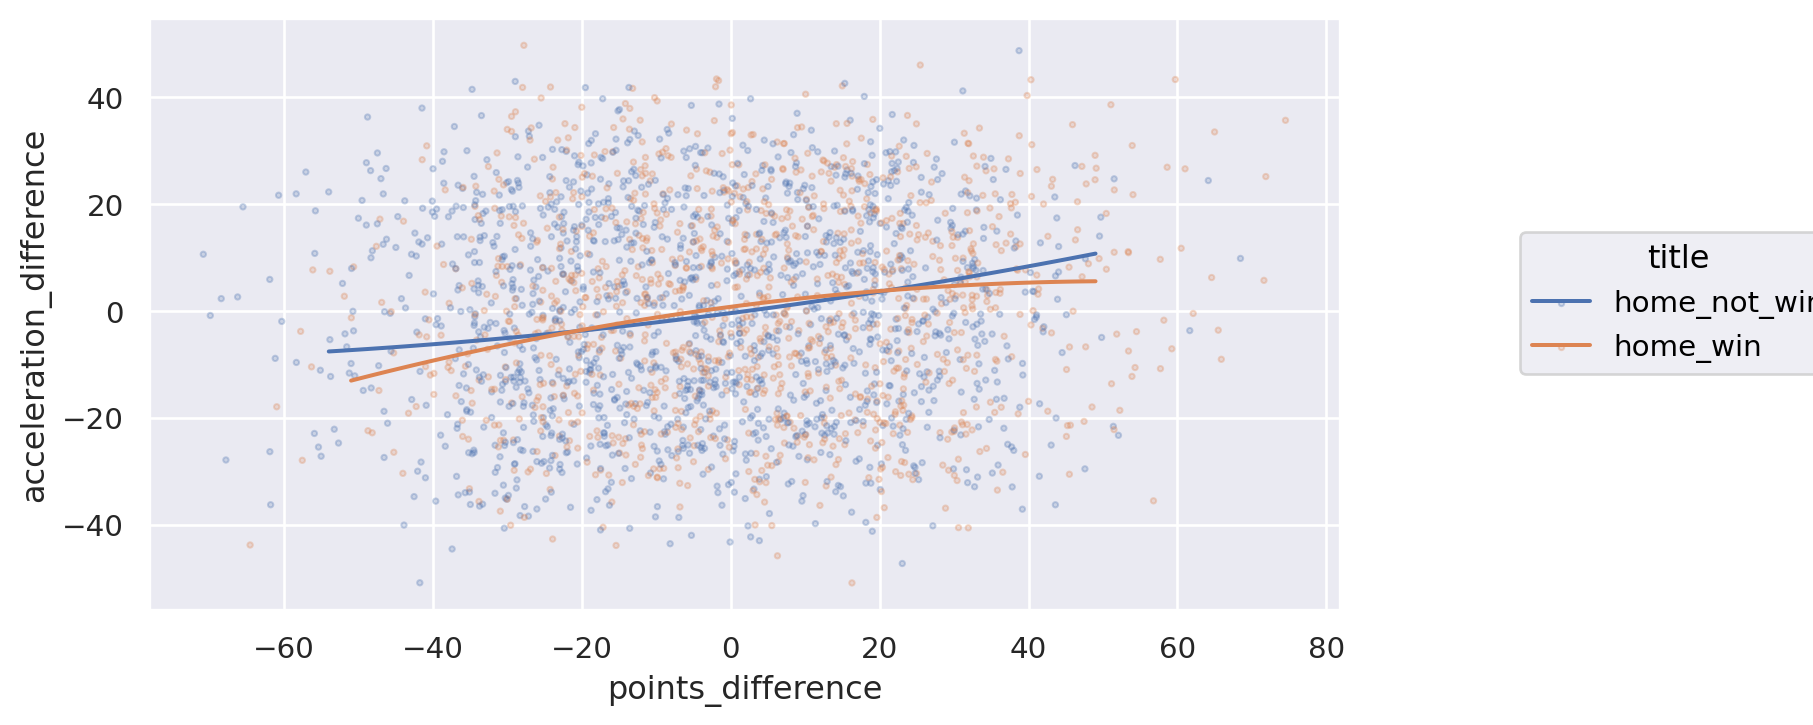

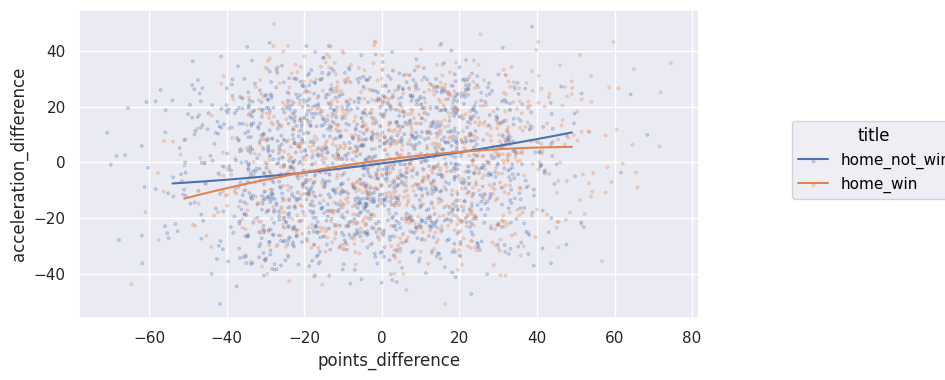

In [39]:
import seaborn.objects as so

fig = plt.figure(figsize=(8, 4))
(so
 .Plot(X_trn.assign(title=y_trn.apply(lambda x: 'home_win' if x == 1 else 'home_not_win')), x='points_difference', y='acceleration_difference', color='title')
 .add(so.Dots(alpha=.3, pointsize=2), so.Jitter(x=70, y=60))
 .add(so.Line(), so.PolyFit())
 .on(fig)
 .plot()
 )